In [3]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [4]:
# Dla bazy danych ver3
df = pd.read_csv("data/ver3.csv")
print(df.shape)
df.head()
target = "TenYearCHD"
numFeatures = ['age', 'log_totChol','log_sysBP', 'log_BMI', 'heartRate', 'log_glucose']
catFeatures = [ 'male', 'education', 'currentSmoker', 'prevalentHyp']

(3603, 11)


In [5]:
from sklearn import preprocessing

mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał naszą mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy danę (tworzymy mapę) i od razu ją nakadamy na zmienną na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df[feature])

    # Zapiszmy nasza mapę, aby móc odzyskać oryginalne dane bez problemu
    mapy[feature] = le

In [6]:
features = df.columns.tolist()
features.remove(target)
print(features)

['male', 'age', 'education', 'currentSmoker', 'prevalentHyp', 'heartRate', 'log_glucose', 'log_BMI', 'log_sysBP', 'log_totChol']


In [13]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="hist", grow_policy="depthwise",
           verbosity=1, silent=False): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [14]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

---

###### Random search

In [15]:
import random
results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 9), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


[04:44:41] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:44:41] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:44:42] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

0.7131842636189945 (4, 0.7484860297938934, 0.381262241816437, 8.718879115813555, 6.34867494947316)
[04:44:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:44:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:44:54] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, 

0.7036324554154609 (4, 0.8222838759604986, 0.18976108460082514, 1.4943268330259207, 3.5385010552464258)
[04:45:05] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:06] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:06] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_ro

0.7073006600049718 (6, 0.24342023220500453, 0.32977126057746153, 1.461277510412089, 6.9232189571054406)
[04:45:20] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:20] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:21] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_ro

0.7175407318672026 (4, 0.2806200350912784, 0.7002300490382282, 9.469259073153669, 2.521344519660169)
[04:45:35] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round

0.7136180242894327 (4, 0.8106807675241461, 0.4120475062914425, 2.8468705432256614, 9.405572257795644)
[04:45:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.716201489576364 (4, 0.7621212804699117, 0.8161951566701451, 9.086117984790747, 4.530424784249917)
[04:45:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:58] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:45:58] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round,

0.7147038515580328 (8, 0.4962949960705517, 0.409387329163616, 7.758908457131033, 7.464785943543292)
[04:46:11] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:12] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:13] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round,

0.7073182505595936 (4, 0.32247276119027024, 0.25580220941776943, 7.67947531348547, 6.351737903810056)
[04:46:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.7163464809200837 (9, 0.3518886395520989, 0.7923940697370115, 9.526023823876175, 1.5619537776889303)
[04:46:38] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:39] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:39] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.71324071236011 (6, 0.6403724176160227, 0.4308437581566652, 6.094061329904667, 4.519934562475285)
[04:46:52] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:52] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, 

0.7072743217646754 (8, 0.2490714227194241, 0.23784753725451876, 6.76159936933286, 7.221146579542066)
[04:47:07] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:08] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:08] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round

0.7002478195539965 (6, 0.5241056094234499, 0.14422290172038388, 0.15187871718673196, 8.545355412201637)
[04:47:17] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:18] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:19] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_ro

0.7198422260182428 (7, 0.12466582896625589, 0.8890602270688519, 6.288360772670767, 0.42368662754762365)
[04:47:31] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:32] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:33] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_ro

0.7144955840383258 (9, 0.17032663432506984, 0.5166683802834573, 8.313467243584705, 0.7156073218419412)
[04:47:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:46] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:46] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_rou

0.7125901216549344 (3, 0.8836824297848865, 0.5566830650371996, 3.5447774396968468, 9.338203043785182)
[04:47:56] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:56] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:47:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.7131344870321568 (5, 0.40307952378150336, 0.3642460534586547, 0.9435546763838831, 6.671156331415111)
[04:48:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:10] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_rou

0.7066487953778785 (5, 0.10189864184051088, 0.6577254190704823, 8.992944530102745, 6.589487202597116)
[04:48:20] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:20] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:21] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.715972941243394 (4, 0.6801241583366393, 0.8311873998046656, 1.2180145018503796, 9.386814265992466)
[04:48:35] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round

0.7115543518583 (5, 0.5245861516616775, 0.2468618950814867, 8.495644100276175, 6.849765212868007)
[04:48:49] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:49] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:48:50] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, r

0.7029143615593 (4, 0.43142758698971073, 0.16000425079706027, 3.179108274118053, 3.4345934183400164)
[04:49:00] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:01] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:02] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round

0.7161869263836067 (3, 0.630148922044142, 0.3756040172966826, 4.0182885828684665, 1.5220765255130908)
[04:49:12] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:12] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:12] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.7191970863391081 (7, 0.40530259768494503, 0.8876007529305222, 3.948188802789303, 9.10835973034996)
[04:49:25] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:26] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:26] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round

0.7140313456651655 (9, 0.4539740524111652, 0.30851217607408865, 1.348936882571482, 7.875584642336552)
[04:49:41] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:42] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:42] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_roun

0.7151711968294527 (3, 0.395620849956725, 0.3074193351953685, 7.744517161129718, 5.304656523692907)
[04:49:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:49:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round,

0.7099518375122206 (3, 0.3554403537484703, 0.28987149704823534, 6.0250673476177, 7.703122449496931)


In [16]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.7208672072014515, (9, 0.13922186554177376, 0.5763435166387878, 0.3391858538422976, 4.967435050869122))
(0.7203696908033901, (8, 0.3407118301973239, 0.8605444788998644, 6.04143844990819, 2.588707555948732))
(0.7203519819880471, (5, 0.25250705308938387, 0.8962489056606382, 0.5736546156252453, 6.1287633650190765))
(0.7198422260182428, (7, 0.12466582896625589, 0.8890602270688519, 6.288360772670767, 0.42368662754762365))
(0.7191970863391081, (7, 0.40530259768494503, 0.8876007529305222, 3.948188802789303, 9.10835973034996))
(0.7190819082987432, (9, 0.4085156516497386, 0.42285907113917076, 4.872978478506555, 2.399047844709985))
(0.7189737056585795, (5, 0.26514847721297974, 0.7913715951650099, 2.416947894833952, 0.8729826627183945))
(0.7189133673655599, (6, 0.41612372484181304, 0.8069324045071644, 4.947728121149016, 8.444513165855968))
(0.7187677037856035, (9, 0.8686616544697796, 0.822563948938915, 0.544157784884709, 6.899621288509431))
(0.7187669055614511, (4, 0.47845878381816165, 0.868300

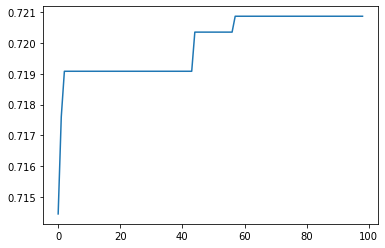

In [17]:
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

In [18]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=3, subsample = 0.21727819856193556, colsample_bytree = 0.8797086489142867, lambdaX=0.6732199816833839, gamma=1.8040461137086128)
print(np.mean(testResults))

modelXGB_rs = {
    "name":"XGB_rs",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=3, subsample = 0.21727819856193556, colsample_bytree = 0.8797086489142867, lambdaX=0.6732199816833839, gamma=1.8040461137086128',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

[04:50:08] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:50:08] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:50:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

In [19]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_XGB_1_ver3_rs.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB_rs, fp)